# Data Preprocessing and Visualization

## Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

/tmp/ipykernel_11329/1042032473.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2025-11-10 03:57:53.339969: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 03:57:54.652475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-10 03:57:54.652767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

## Load Data

In [2]:
# Import folders
folders = ["damage", "no_damage"]

# Load images into data as arrays for RBG values
data = []
for folder in folders:
    folder_path = folder
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder_path, fname)
            
            # Load the RGB image (128x128)
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0  # normalize # normalize all the values
            img_array = img_array.flatten()  # flatten for ANN
            data.append({
                "image_path": img_array,   # store pixel array instead of path
                "label": folder
            })

data = pd.DataFrame(data) # Go from array to dataframe
print(data.head())

                                          image_path   label
0  [0.26666668, 0.32941177, 0.21568628, 0.2627451...  damage
1  [0.4117647, 0.40392157, 0.3137255, 0.43137255,...  damage
2  [0.3019608, 0.34901962, 0.3019608, 0.29803923,...  damage
3  [0.47058824, 0.48235294, 0.36862746, 0.4588235...  damage
4  [0.23137255, 0.32941177, 0.1764706, 0.21176471...  damage


In [3]:
# Check max and min values and if everything rescaled correctly
all_values = np.concatenate(data['image_path'].to_numpy())  # flatten column of arrays
print(all_values.max(), all_values.min())

1.0 0.0


### Check Data Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  21322 non-null  object
 1   label       21322 non-null  object
dtypes: object(2)
memory usage: 333.3+ KB


In [5]:
img = Image.open("damage/-93.795_30.03779.jpeg") # double check pixel sizes
img.size

(128, 128)

## Data Preprocessing

In [6]:
data['label'] = data['label'].astype("string") # turn from object into string
data = pd.get_dummies(data, columns=["label"], drop_first=True) # Do one hot encoding

In [7]:
data.columns

Index(['image_path', 'label_no_damage'], dtype='object')

In [8]:
data['label_no_damage'] = data['label_no_damage'].apply(lambda x: 1 if x == False else 0) # concert true false to 1 or 0
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       21322 non-null  object
 1   label_no_damage  21322 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 333.3+ KB


image_path         0
label_no_damage    0
dtype: int64

In [9]:
data.head

<bound method NDFrame.head of                                               image_path  label_no_damage
0      [0.26666668, 0.32941177, 0.21568628, 0.2627451...                1
1      [0.4117647, 0.40392157, 0.3137255, 0.43137255,...                1
2      [0.3019608, 0.34901962, 0.3019608, 0.29803923,...                1
3      [0.47058824, 0.48235294, 0.36862746, 0.4588235...                1
4      [0.23137255, 0.32941177, 0.1764706, 0.21176471...                1
...                                                  ...              ...
21317  [0.32156864, 0.34509805, 0.23529412, 0.3372549...                0
21318  [0.1764706, 0.23137255, 0.16470589, 0.18431373...                0
21319  [0.2, 0.25490198, 0.15686275, 0.22745098, 0.28...                0
21320  [0.35686275, 0.3882353, 0.29411766, 0.36078432...                0
21321  [0.5254902, 0.54901963, 0.4392157, 0.49803922,...                0

[21322 rows x 2 columns]>

Damage is 1, no damage is 0

## Split into train and test sets

In [10]:
X = np.stack(data["image_path"].values)
Y = data["label_no_damage"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

# ANN

## Setup and Train model

In [11]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(128*128*3,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               25166336  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25314177 (96.57 MB)
Trainable params: 25314177 (96.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(X_train, Y_train, validation_split=0.2, epochs=1, batch_size=32, verbose=2)

2025-11-10 03:58:36.661507: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


374/374 - 60s - loss: 0.8738 - accuracy: 0.6215 - val_loss: 0.5960 - val_accuracy: 0.6958 - 60s/epoch - 159ms/step


## Testing model on test set

In [15]:
y_pred = model.predict(X_test)

200/200 [==============================] - 2s 9ms/step


In [16]:
y_pred_final=[]
for i in y_pred:
    # return the index with the highest probability
    if i > .50:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)

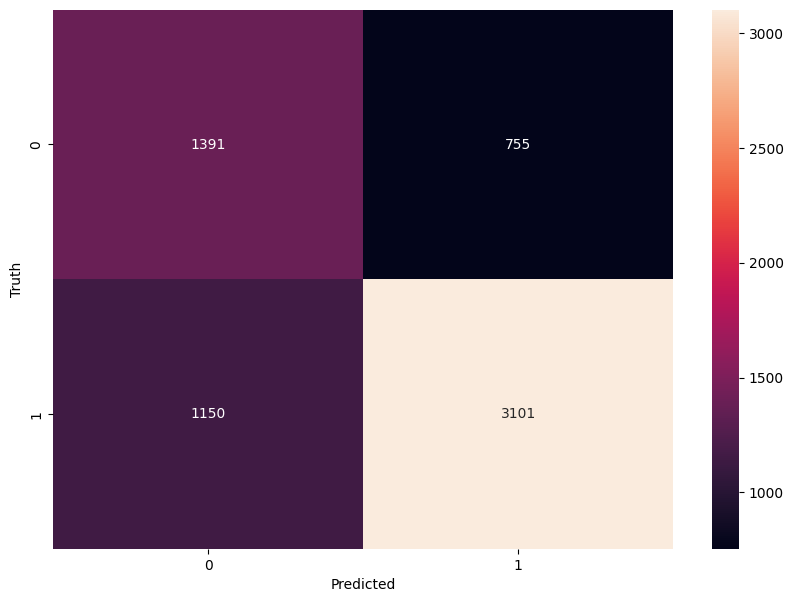

In [17]:
cm=confusion_matrix(Y_test,y_pred_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [18]:
print(classification_report(Y_test,y_pred_final))

              precision    recall  f1-score   support

           0       0.55      0.65      0.59      2146
           1       0.80      0.73      0.77      4251

    accuracy                           0.70      6397
   macro avg       0.68      0.69      0.68      6397
weighted avg       0.72      0.70      0.71      6397



# CNN

In [19]:
folders = ["damage", "no_damage"]

dataCNN = []
for folder in folders:
    folder_path = folder
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder_path, fname)
            # Load the RGB image (128x128)
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0  # normalize
            dataCNN.append({
                "image_path": img_array,   # store pixel array instead of path
                "label": folder
            })

dataCNN = pd.DataFrame(dataCNN)
print(dataCNN.head())
dataCNN.tail

                                          image_path   label
0  [[[0.26666668, 0.32941177, 0.21568628], [0.262...  damage
1  [[[0.4117647, 0.40392157, 0.3137255], [0.43137...  damage
2  [[[0.3019608, 0.34901962, 0.3019608], [0.29803...  damage
3  [[[0.47058824, 0.48235294, 0.36862746], [0.458...  damage
4  [[[0.23137255, 0.32941177, 0.1764706], [0.2117...  damage


<bound method NDFrame.tail of                                               image_path      label
0      [[[0.26666668, 0.32941177, 0.21568628], [0.262...     damage
1      [[[0.4117647, 0.40392157, 0.3137255], [0.43137...     damage
2      [[[0.3019608, 0.34901962, 0.3019608], [0.29803...     damage
3      [[[0.47058824, 0.48235294, 0.36862746], [0.458...     damage
4      [[[0.23137255, 0.32941177, 0.1764706], [0.2117...     damage
...                                                  ...        ...
21317  [[[0.32156864, 0.34509805, 0.23529412], [0.337...  no_damage
21318  [[[0.1764706, 0.23137255, 0.16470589], [0.1843...  no_damage
21319  [[[0.2, 0.25490198, 0.15686275], [0.22745098, ...  no_damage
21320  [[[0.35686275, 0.3882353, 0.29411766], [0.3607...  no_damage
21321  [[[0.5254902, 0.54901963, 0.4392157], [0.49803...  no_damage

[21322 rows x 2 columns]>

In [20]:
dataCNN.size

42644

In [21]:
len(dataCNN['image_path'][0])

128

In [22]:
dataCNN['image_path'][0].shape

(128, 128, 3)

In [23]:
dataCNN['label'] = dataCNN['label'].astype("string")
dataCNN = pd.get_dummies(dataCNN, columns=["label"], drop_first=True)

In [24]:
dataCNN['label_no_damage'] = dataCNN['label_no_damage'].apply(lambda x: 1 if x == False else 0)
dataCNN.info()
dataCNN.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       21322 non-null  object
 1   label_no_damage  21322 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 333.3+ KB


image_path         0
label_no_damage    0
dtype: int64

In [25]:

X = np.stack(dataCNN["image_path"].values)
Y = dataCNN["label_no_damage"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

In [26]:
X_train.shape

(14925, 128, 128, 3)

In [ ]:
import gc
from tensorflow.keras import backend as K

# Clear the previous model from memory
K.clear_session()
gc.collect()

In [27]:
# Intializing a sequential model
model_lenet5 = Sequential()

# Layer 1: Convolutional layer with 6 filters of size 5x5, followed by average pooling
model_lenet5.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)))
model_lenet5.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 5x5, followed by average pooling
model_lenet5.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
model_lenet5.add(Flatten())

# Layer 3: Fully connected layer with 120 neurons
model_lenet5.add(Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
model_lenet5.add(Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 10 for MNIST)
model_lenet5.add(Dense(1, activation='sigmoid'))


model_lenet5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lenet5.fit(X_train, Y_train, validation_split=0.2, epochs=1, batch_size=32, verbose=2)


2025-11-10 04:00:03.880155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


374/374 - 39s - loss: 0.4157 - accuracy: 0.8240 - val_loss: 0.3197 - val_accuracy: 0.8771 - 39s/epoch - 103ms/step


In [28]:
import gc
from tensorflow.keras import backend as K

# Clear the previous model from memory
K.clear_session()
gc.collect()

5650

In [29]:
# Intializing a sequential model
alternatemodel_lenet5 = Sequential()

# Layer 1: Convolutional layer with 6 filters of size 5x5, followed by average pooling
alternatemodel_lenet5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
alternatemodel_lenet5.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 5x5, followed by average pooling
alternatemodel_lenet5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
alternatemodel_lenet5.add(MaxPooling2D(pool_size=(2, 2)))

alternatemodel_lenet5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
alternatemodel_lenet5.add(MaxPooling2D(pool_size=(2, 2)))

alternatemodel_lenet5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
alternatemodel_lenet5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
alternatemodel_lenet5.add(Flatten())
alternatemodel_lenet5.add(Dropout(0.5))
# Layer 3: Fully connected layer with 120 neurons
alternatemodel_lenet5.add(Dense(512, activation='relu'))
# Layer 4: Fully connected layer with 84 neurons
alternatemodel_lenet5.add(Dense(1, activation='sigmoid'))


alternatemodel_lenet5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
alternatemodel_lenet5.fit(X_train, Y_train, validation_split=0.2, epochs=1, batch_size=32, verbose=2)

2025-11-10 04:00:45.208705: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


374/374 - 80s - loss: 0.3930 - accuracy: 0.8183 - val_loss: 0.2267 - val_accuracy: 0.9146 - 80s/epoch - 213ms/step


200/200 [==============================] - 10s 48ms/step


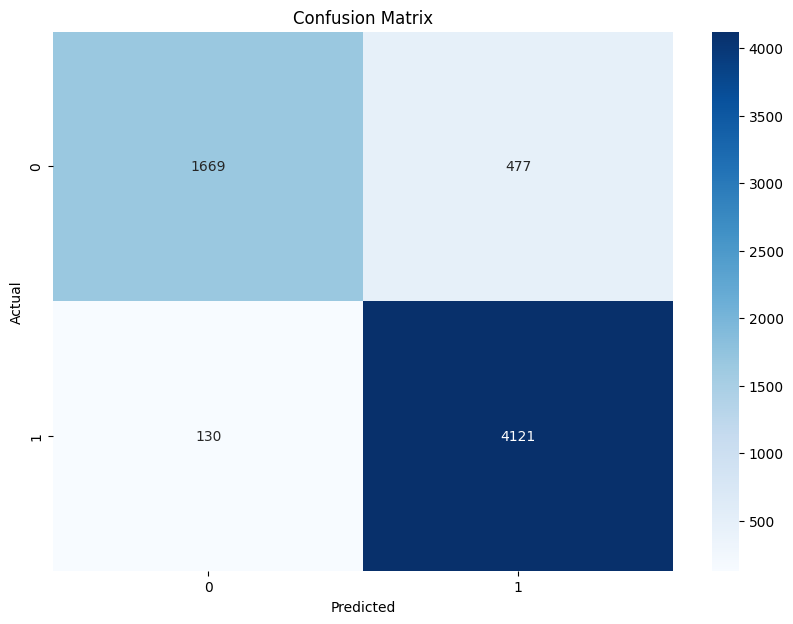

In [30]:
y_pred = alternatemodel_lenet5.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)

# Plot
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
print(classification_report(Y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      2146
           1       0.90      0.97      0.93      4251

    accuracy                           0.91      6397
   macro avg       0.91      0.87      0.89      6397
weighted avg       0.91      0.91      0.90      6397



In [32]:
alternatemodel_lenet5.save("damage_model.keras")
alternatemodel_lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0